# Identification of human sequences

We'll try to replicate the [Classifying human DNA sequence and random ATCG sequences, using keras CNN](https://github.com/onceupon/deep_learning_DNA) problem, but using PyTorch instead.

In [20]:
import torch
import torch.utils.data as data_utils
from torch import nn
import pandas as pd
from numpy import argmax
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from numpy import vstack
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
import os

In [21]:
dataset = pd.read_csv("datasets/human-exercise.csv")
print(dataset.shape)
dataset

(20000, 2)


,sequence,label
0,CTACTCGGGAGGCTGAGGCAGGAGAATCACTTGAACCAGGGAGTCA...,1
1,CACCTTATCCAGAGAAGCTTCTTCTTTTAGAAAATCAAGCAAAACA...,1
2,AAAGGGGCTGATAGAAAAATAAAGAGATTTGGCCAGGTACGGTGGC...,1
3,AAGTGGATATTCAGACCTCCTTGAGGCCTTCGTTGGAAACGGGATT...,1
4,ATACCATGACAAAGATATTATTAGCCAATTTTTAGAGAGAAGGAAA...,1
...,...,...
19995,AAGACGAGTGGTTACCCCCTGTGAGACTGCCGCGCGTGGTGGTCGG...,0
19996,ACGAGGCCATCTAGAGCGCAACGAAACTGCAAGAAAATACGTCCGA...,0
19997,CATCTTTACCCAATTTGTGTGTGGAAAGGTGTCAGCGATGCTTTGG...,0
19998,ATAAGTAACTCCAGTCGAGCGGAAGGTATAGTGGCACGGGGTTTAG...,0


As we can see, this dataset contains the sequence and the corresponding positive/negative class labels, with positive class labels corresponding to the human DNA. The amount of positive and negative examples is evenly distributed across the two classes.

1    10000
0    10000
Name: label, dtype: int64


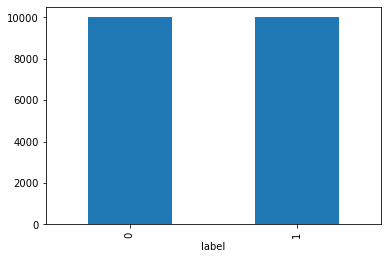

In [22]:
# plot the distribution of each class
dataset.groupby('label').size().plot(kind='bar')

print(dataset['label'].value_counts())

We need now to split the dataset into training, test and validation sets.

In [23]:
fps_x = dataset['sequence'].values
fps_y = dataset['label'].values

x, x_test, y, y_test = train_test_split(
    fps_x, fps_y,
    test_size=0.2,
    train_size=0.8,
    stratify=fps_y
)
x_train, x_cv, y_train, y_cv = train_test_split(
    x, y,
    test_size=0.25,
    train_size=0.75,
    stratify=y
)

Now we need to one hot encode the sequences.

In [24]:
import encoding as enc
x_train_enc = enc.DNAEncoding(x_train)
x_train = x_train_enc.one_hot_encode()

x_test_enc = enc.DNAEncoding(x_test)
x_test = x_test_enc.one_hot_encode()

x_cv_enc = enc.DNAEncoding(x_cv)
x_cv = x_cv_enc.one_hot_encode()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)


(12000, 250, 4)
(12000,)
(4000, 250, 4)
(4000,)
(4000, 250, 4)
(4000,)


In [25]:
# convert to torch.tensor
train_data = data_utils.TensorDataset(
    torch.tensor(x_train, dtype=torch.float),
    torch.tensor(y_train, dtype=torch.long)
)
test_data = data_utils.TensorDataset(
    torch.tensor(x_test, dtype=torch.float),
    torch.tensor(y_test, dtype=torch.long)
)
valid_data = data_utils.TensorDataset(
    torch.tensor(x_cv, dtype=torch.float),
    torch.tensor(y_cv, dtype=torch.long)
)

batch_size = 16

# Data loader
trainloader = data_utils.DataLoader(
    train_data,
    shuffle=True,
    batch_size=batch_size
)
testloader = data_utils.DataLoader(
    test_data,
    shuffle=True,
    batch_size=batch_size
)
validloader = data_utils.DataLoader(
    valid_data,
    shuffle=True,
    batch_size=batch_size
)

Building the model equivalent to the one in the paper.

In [26]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(4, 20, 10, stride=1, padding=0)
        self.fc1 = nn.Linear(940, 10)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)

        self.max_pool = nn.MaxPool1d(10, stride=5)

        self.act1 = nn.ReLU()
        self.act2 = nn.ReLU()
        self.act3 = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.act1(x)
        x = self.max_pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.act2(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.act3(x)

        return x

In [27]:
def traindata(device, model, epochs, optimizer, loss_function, train_loader, valid_loader):
    # Early stopping
    last_loss = 100
    patience = 2
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    for epoch in range(1, epochs+1):
        model.train()

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward and backward propagation
            output = model(inputs)
            loss = loss_function(output, targets)
            loss.backward()
            optimizer.step()

            # Show progress
            if i % 100 == 0 or i == len(train_loader):
                print(f'[{epoch}/{epochs}, {i}/{len(train_loader)}] loss: {loss.item():.8}')

        # Early stopping
        current_loss = validation(model, device, valid_loader, loss_function)
        print('The Current Loss:', current_loss)

        if current_loss > last_loss:
            trigger_times += 1
            print('Trigger Times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\nStart to test process.')
                return model

        else:
            print('trigger times: 0')
            trigger_times = 0

        last_loss = current_loss
        scheduler.step(current_loss)

    return model


def validation(model, device, valid_loader, loss_function):
    model.eval()
    loss_total = 0

    # Test validation data
    with torch.no_grad():
        for (inputs, targets) in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            output = model(inputs)
            loss = loss_function(output, targets)
            loss_total += loss.item()

    return loss_total / len(valid_loader)


def test(device, model, test_loader):
    model.eval()
    predictions, actuals = list(), list()
    with torch.no_grad():
        for (inputs, targets) in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            yhat = model(inputs)
            yhat = yhat.cpu().detach().numpy()
            actual = targets.cpu().numpy()
            actual = actual.reshape((len(actual), 1))
            yhat = argmax(yhat, axis=1)
            yhat = yhat.reshape((len(yhat), 1))
            predictions.append(yhat)
            actuals.append(actual)

    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    mcc = matthews_corrcoef(actuals, predictions)
    report = confusion_matrix(actuals, predictions)
    return acc, mcc, report

In [28]:
torch.manual_seed(2022)
os.environ["CUDA_VISIBLE_DEVICES"] = '4,5'
device = torch.device('cuda:0')

epochs = 100
lr = 0.004
loss_function = nn.CrossEntropyLoss()
model = Net().to(device)
optimizer = Adam(model.parameters(), lr=lr)

model = traindata(device, model, epochs, optimizer, loss_function, trainloader, validloader)

# Test
acc, mcc, report = test(device, model, testloader)
print('Accuracy: %.3f' % acc)
print('MCC: %.3f' % mcc)
print(report)

[1/100, 0/750] loss: 0.67008334
[1/100, 100/750] loss: 0.53343385
[1/100, 200/750] loss: 0.55693603
[1/100, 300/750] loss: 0.47723076
[1/100, 400/750] loss: 0.41177076
[1/100, 500/750] loss: 0.39757156
[1/100, 600/750] loss: 0.38926074
[1/100, 700/750] loss: 0.38877293
The Current Loss: 0.36394351470470426
trigger times: 0
[2/100, 0/750] loss: 0.32400948
[2/100, 100/750] loss: 0.43998554
[2/100, 200/750] loss: 0.45562145
[2/100, 300/750] loss: 0.39469269
[2/100, 400/750] loss: 0.55708808
[2/100, 500/750] loss: 0.43704766
[2/100, 600/750] loss: 0.39265126
[2/100, 700/750] loss: 0.38110796
The Current Loss: 0.33235063624382016
trigger times: 0
[3/100, 0/750] loss: 0.38152137
[3/100, 100/750] loss: 0.4622888
[3/100, 200/750] loss: 0.3169786
[3/100, 300/750] loss: 0.31704336
[3/100, 400/750] loss: 0.37896398
[3/100, 500/750] loss: 0.43811357
[3/100, 600/750] loss: 0.44014138
[3/100, 700/750] loss: 0.3773056
The Current Loss: 0.36440022361278535
Trigger Times: 1
[4/100, 0/750] loss: 0.31583